## Importing data from KaggleHub

In [ ]:
import kagglehub

path = kagglehub.dataset_download("maheshmani13/nifty-50-nsei-index-price-data-2015-2023")

## Importing Necessary Library

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as tsatools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline

## Loading Dataset

In [ ]:
files = os.listdir(path)
files

['NSEI 2015-2023.csv']

In [ ]:
df = pd.read_csv(os.path.join(path, files[0]),index_col=["Date"], parse_dates=["Date"])

In [ ]:
df.drop(columns=['Open', "High", "Low", "Volume"], inplace=True)

In [ ]:
df.shape

(2213, 1)


## Top 5 rows in Dataset

In [ ]:
df.head()

,Close
Date,
2015-01-02,8395.450195
2015-01-05,8378.400391
2015-01-06,8127.350098
2015-01-07,8102.100098
2015-01-08,8234.599609


## Last 5 rows of Dataset

In [ ]:
df.tail()

,Close
Date,
2023-12-22,21349.400391
2023-12-26,21441.349609
2023-12-27,21654.750000
2023-12-28,21778.699219
2023-12-29,21731.400391


## Dataset has no null values

In [ ]:
df.Close.isna().sum()

0

## Plotting Data with Maximum value and Minimum value

In [ ]:
def plot_attribute(df, attritube ,start='2015-01-02', end='2023-12-29',color ='blue'):
    fig, ax = plt.subplots(1, figsize=(20,5))
    ax.plot(df[start:end].index, df[start:end][attritube],'tab:{}'.format(color))
    ax.set_title("Nifty stock {} from 2015 to 2023".format(attritube))

    ax.axhline(y=df[start:end].describe()[attritube]["max"],linewidth=2, color='m')
    ax.axhline(y=df[start:end].describe()[attritube]["min"],linewidth=2, color='c')
    ax.axvline(x=df[attritube].idxmax(),linewidth=2, color='b')
    ax.axvline(x=df[attritube].idxmin() ,linewidth=2, color='y')

    ax.text(x=df[attritube].idxmax(),
            y=df[start:end].describe()[attritube]["max"],
            s='MAX',
            horizontalalignment='right',
            verticalalignment='bottom',
            color='blue',
            fontsize=20)

    ax.text(x=df[attritube].idxmin(),
            y=df[start:end].describe()[attritube]["min"],
            s='MIN',
            horizontalalignment='left',
            verticalalignment='top',
            color='red',
            fontsize=20)

    plt.show()
    print("Max Value :  ",df[start:end].describe()[attritube]["max"])
    print("Min Value :  ",df[start:end].describe()[attritube]["min"])

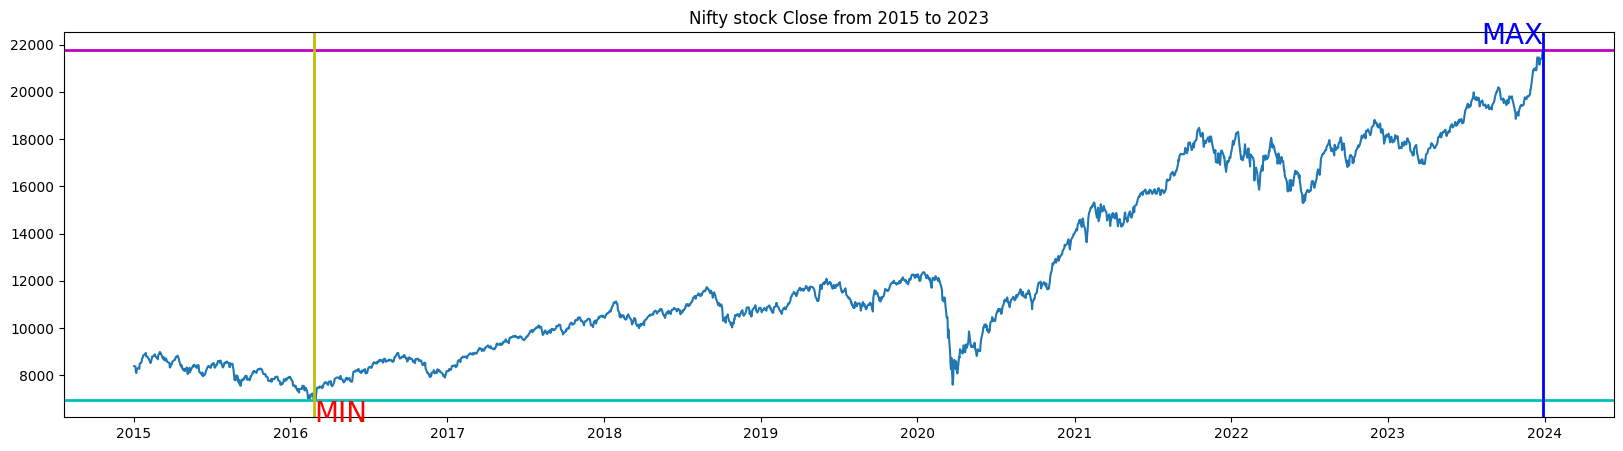

Max Value :   21778.699219
Min Value :   6970.600098


In [ ]:
plot_attribute(df, "Close")

In [ ]:
analysis_df = df[:].copy()
analysis_df = analysis_df.asfreq("D")
analysis_df["Close"] = analysis_df["Close"].fillna(method="ffill")
analysis_df.head()

<ipython-input-15-9f9d1e141ce9>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  analysis_df["Close"] = analysis_df["Close"].fillna(method="ffill")


,Close
Date,
2015-01-02,8395.450195
2015-01-03,8395.450195
2015-01-04,8395.450195
2015-01-05,8378.400391
2015-01-06,8127.350098


## Decompose Seasonal Data

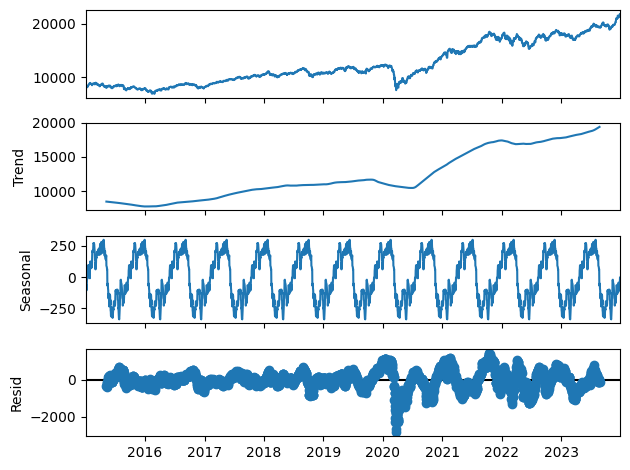

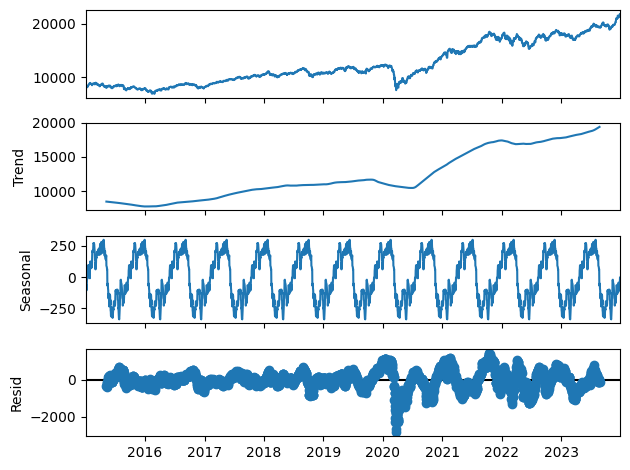

In [ ]:
decompose_result_mult = seasonal_decompose(analysis_df[["Close"]], model="additive", period=252)
analysis_df["trend"] = decompose_result_mult.trend
analysis_df["seasonal"]   = decompose_result_mult.seasonal
decompose_result_mult.plot()

## Nifty index with trend and seasonality

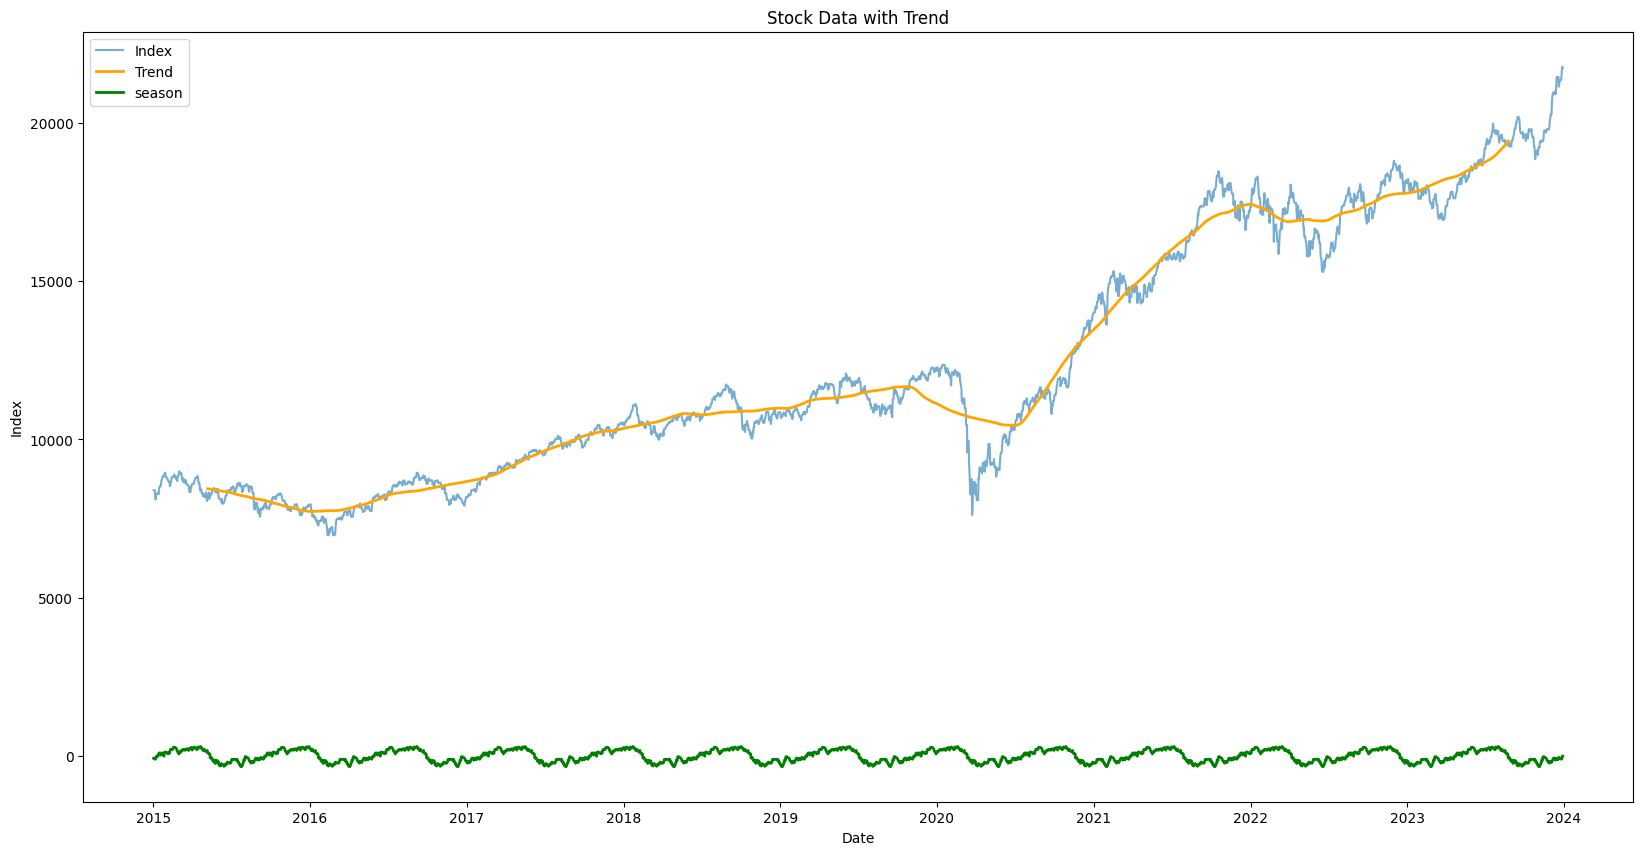

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(analysis_df['Close'], label='Index', alpha=0.6)
plt.plot(analysis_df["trend"], label='Trend', color='orange', linewidth=2)
plt.plot(analysis_df["seasonal"], label='season', color='green', linewidth=2)

plt.title('Stock Data with Trend')
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend()
plt.show()

## Data Stationarity Test

In [ ]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(analysis_df.Close)

ADF Statistic: 0.577709
p-value: 0.987053
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Non-stationary


## Evaluate Model with Various Metrics

In [ ]:
def evaluate_model(y_true, y_pred):
  mae = metrics.mean_absolute_error(y_true, y_pred)
  mse = metrics.mean_squared_error(y_true, y_pred)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  rmse = np.sqrt(mse)
  r2 = metrics.r2_score(y_true, y_pred)

  return mae, mse, mape, rmse, r2


## Plotting Moving Average

In [ ]:
def plot_MA(data, cma, tma):
  fig, ax = plt.subplots(figsize=(20, 5))
  ax = data.plot(ax=ax, color='black', linewidth=0.25)
  cma.plot(ax=ax, linewidth=2)
  tma.plot(ax=ax, style='--', linewidth=2)
  ax.set_xlabel('Date')
  ax.set_ylabel('Index')
  ax.legend(['Index', 'Centered Moving Average', 'Trailing Moving Average'])
  plt.show()

## Plotting Autocorrelation and Partial Autocorrelation Plot for seasonality test

<Figure size 2000x1000 with 0 Axes>

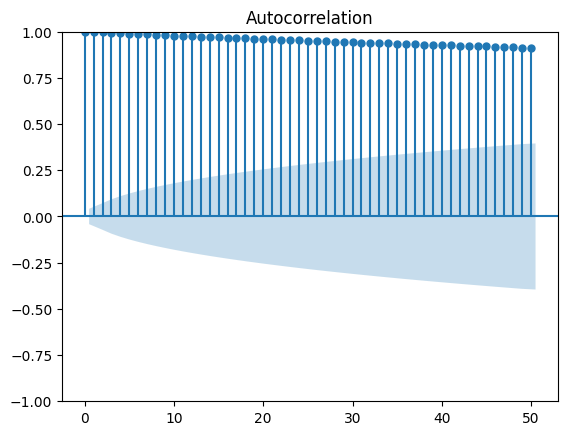

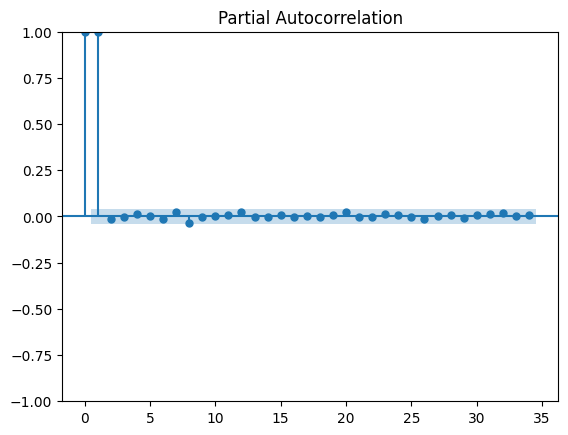

In [ ]:
plt.figure(figsize=(20, 10))
plot_acf(df['Close'], lags=50)
plot_pacf(df['Close'])
plt.show()

## Test size of training


In [ ]:
test_size = 200

## Forecasting with Exponential Smoothing

In [ ]:
training_df = df.copy()
training_df.reset_index(inplace=True)

## Splitting data into train and test split

In [ ]:
train = training_df.iloc[:-test_size]["Close"]
test = training_df.iloc[-test_size:]["Close"]

## Fitting the data

In [ ]:
model = ExponentialSmoothing(train,trend='add', seasonal='add', seasonal_periods=252).fit(smoothing_level=0.9)

## Forecasting data

In [ ]:
forecast = model.forecast(test_size)

In [ ]:
model.summary()

Dep. Variable:,Close,No. Observations:,2013
Model:,ExponentialSmoothing,SSE,29876135.265
Optimized:,True,AIC,19847.246
Trend:,Additive,BIC,21282.735
Seasonal:,Additive,AICC,19923.440
Seasonal Periods:,252,Date:,"Fri, 06 Dec 2024"
Box-Cox:,False,Time:,03:10:53
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9000000,alpha,False
smoothing_trend,0.0449378,beta,True


## Evaluating model

In [ ]:
es_mae, es_mse, es_mape, es_rmse, es_r2 = evaluate_model(test,forecast)

print(f"Mean Absolute Error (MAE): {es_mae}")
print(f"Mean Squared Error (MSE): {es_mse}")
print(f"Root Mean Squared Error (RMSE): {es_rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {es_mape}")
print(f"R-squared (R2): {es_r2}")

Mean Absolute Error (MAE): 2171.6740002476567
Mean Squared Error (MSE): 6474112.529889164
Root Mean Squared Error (RMSE): 2544.42774114125
Mean Absolute Percentage Error (MAPE): 11.003032259095793
R-squared (R2): -4.532345524471768


## Comparison of actual data vs predicted data

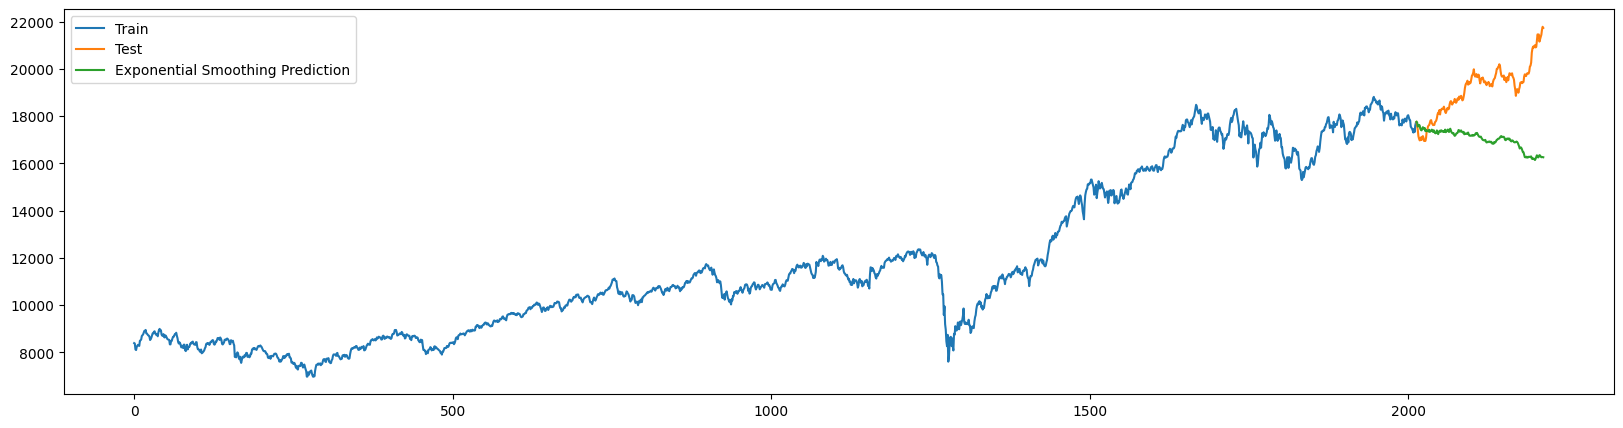

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Exponential Smoothing Prediction' )
plt.legend(loc='best')
plt.show()

## Forecasting with Moving Avearage

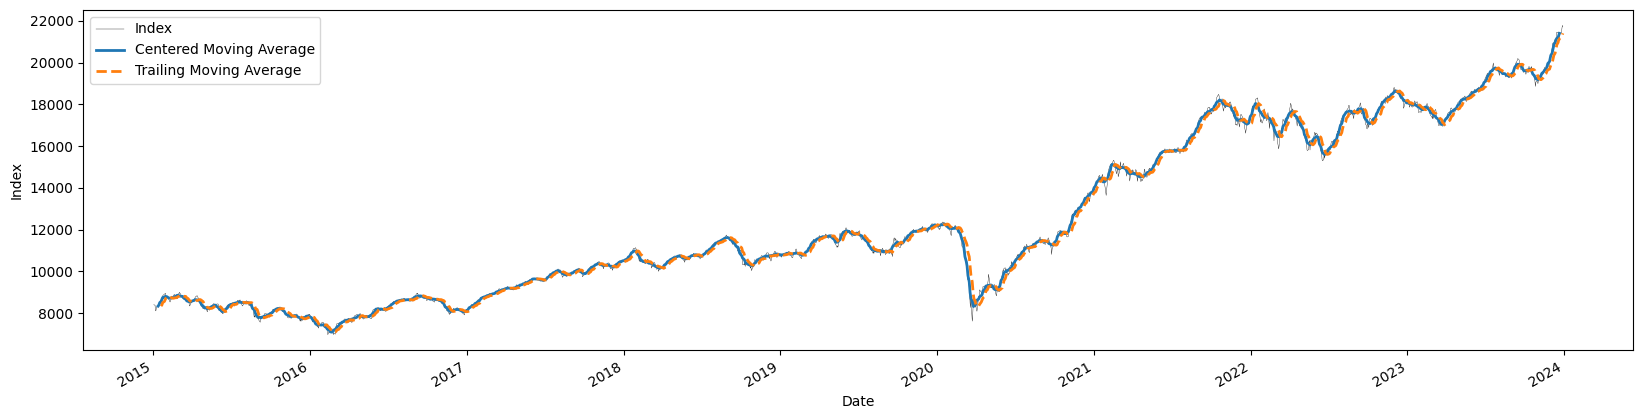

In [ ]:
cma = df.rolling(12, center=True).mean()
tma = df.rolling(12).mean()
plot_MA(df, cma, tma)


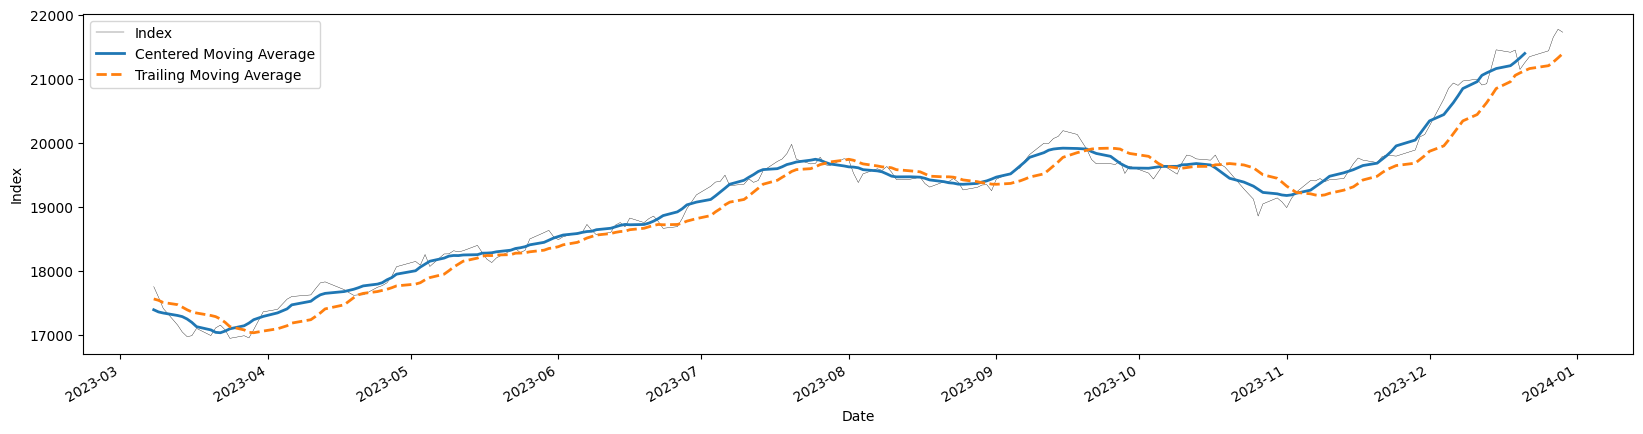

In [ ]:
plot_MA(df[-200:], cma[-200:], tma[-200:])

## Centered Moving Average Model Evaluation

In [ ]:
ma_mae, ma_mse, ma_mape, ma_rmse, ma_r2 = evaluate_model(df[-test_size:-5], cma[-test_size:-5])

print(f"Mean Absolute Error (MAE): {ma_mae}")
print(f"Mean Squared Error (MSE): {ma_mse}")
print(f"Root Mean Squared Error (RMSE): {ma_rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {ma_mape}")
print(f"R-squared (R2): {ma_r2}")

Mean Absolute Error (MAE): 103.67770932350408
Mean Squared Error (MSE): 16516.633596996544
Root Mean Squared Error (RMSE): 128.51705566576192
Mean Absolute Percentage Error (MAPE): 0.5438660406610982
R-squared (R2): 0.9841460555372151


## Trailing Moving Average Model Evaluation

In [ ]:
evaluate_model(df[-test_size:], tma[-test_size:])

Mean Absolute Error (MAE): 222.39486650458332
Mean Squared Error (MSE): 75725.01646638526
Root Mean Squared Error (RMSE): 275.18178803544623
Mean Absolute Percentage Error (MAPE): 1.152879378052928
R-squared (R2): 0.9352904426661967


## Forecasting with ARIMA

In [ ]:
arima_train = df.iloc[:-test_size]
arima_test = df.iloc[-test_size:]
arima_train.tail()

,Close
Date,
2023-02-28,17303.949219
2023-03-01,17450.900391
2023-03-02,17321.900391
2023-03-03,17594.349609
2023-03-06,17711.449219


## Fitting the ARIMA model

In [ ]:
p, d, q = 5, 1, 2

history = arima_train['Close'].tolist()
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(p,d,q))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = arima_test['Close'].iloc[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=17722.606575, expected=17754.400391
predicted=17746.653225, expected=17589.599609
predicted=17576.864276, expected=17412.900391
predicted=17437.285908, expected=17154.300781
predicted=17126.460963, expected=17043.300781
predicted=17059.965355, expected=16972.150391
predicted=16966.605472, expected=16985.599609
predicted=16977.573710, expected=17100.050781
predicted=17112.098210, expected=16988.400391
predicted=16976.375468, expected=17107.500000
predicted=17110.166788, expected=17151.900391
predicted=17161.062450, expected=17076.900391
predicted=17067.473745, expected=16945.050781
predicted=16938.605601, expected=16985.699219
predicted=17003.621515, expected=16951.699219
predicted=16936.571823, expected=17080.699219
predicted=17089.068306, expected=17359.750000
predicted=17365.372901, expected=17398.050781
predicted=17393.902659, expected=17557.050781
predicted=17557.686045, expected=17599.150391
predicted=17606.355517, expected=17624.050781
predicted=17624.306469, expected=1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=18314.306785, expected=18499.349609
predicted=18518.510669, expected=18598.650391
predicted=18588.240941, expected=18633.849609
predicted=18633.648939, expected=18534.400391
predicted=18539.796699, expected=18487.750000
predicted=18480.256027, expected=18534.099609
predicted=18542.709566, expected=18593.849609
predicted=18594.395994, expected=18599.000000
predicted=18590.549278, expected=18726.400391
predicted=18738.465558, expected=18634.550781
predicted=18627.251059, expected=18563.400391
predicted=18560.592227, expected=18601.500000
predicted=18607.795836, expected=18716.150391
predicted=18720.302984, expected=18755.900391
predicted=18747.729318, expected=18688.099609
predicted=18692.074115, expected=18826.000000
predicted=18827.291268, expected=18755.449219
predicted=18756.736867, expected=18816.699219
predicted=18815.414767, expected=18856.849609
predicted=18855.541997, expected=18771.250000
predicted=18779.697312, expected=18665.500000
predicted=18645.502920, expected=1

## Comparison of actual data vs predicted data

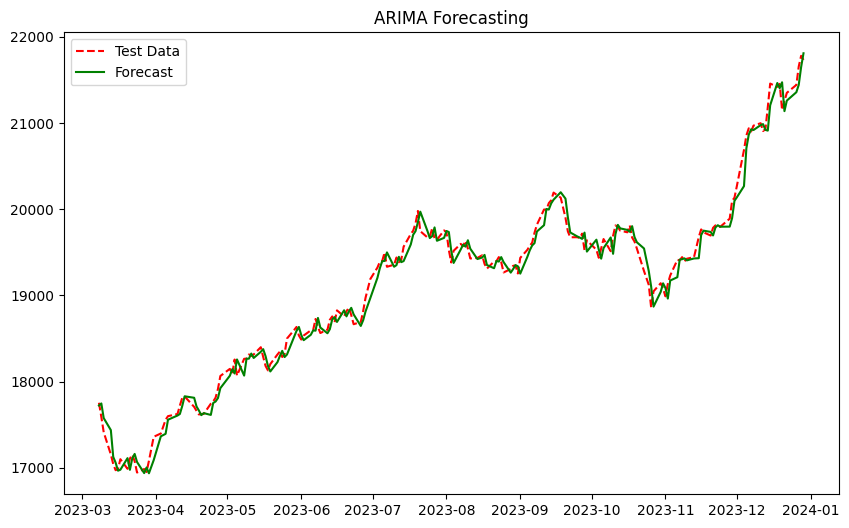

In [ ]:
plt.figure(figsize=(10, 6))
# plt.plot(arima_train, label='Train Data')
plt.plot(arima_test, label='Test Data', color='red', linestyle='--')
plt.plot(arima_test.index ,predictions, label='Forecast', color='green')
plt.legend()
plt.title("ARIMA Forecasting")
plt.show()

## Evaluating ARIMA model

In [ ]:
arima_mae, arima_mse, arima_mape, arima_rmse, arima_r2 = evaluate_model(arima_test["Close"], predictions)

print(f"Mean Absolute Error (MAE): {arima_mae}")
print(f"Mean Squared Error (MSE): {arima_mse}")
print(f"Root Mean Squared Error (RMSE): {arima_rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {arima_mape}")
print(f"R-squared (R2): {arima_r2}")

Mean Absolute Error (MAE): 91.40297395082905
Mean Squared Error (MSE): 13185.46665219239
Root Mean Squared Error (RMSE): 114.82798723391606
Mean Absolute Percentage Error (MAPE): 0.4773848611012796
R-squared (R2): 0.9887325780816205


## Forecasting with Linear Regression

In [ ]:
lr_df = df.copy()
lr_df.head()

,Close
Date,
2015-01-02,8395.450195
2015-01-05,8378.400391
2015-01-06,8127.350098
2015-01-07,8102.100098
2015-01-08,8234.599609


## Adding lags into dataframe for regression model

In [ ]:
lr_df["lag_1"] = lr_df["Close"].shift(1)
lr_df["lag_2"] = lr_df["Close"].shift(2)
lr_df["lag_3"] = lr_df["Close"].shift(3)
lr_df["lag_4"] = lr_df["Close"].shift(4)
lr_df["lag_5"] = lr_df["Close"].shift(5)

In [ ]:
lr_df.dropna(inplace=True)

In [ ]:
x = lr_df[["lag_1", "lag_2", "lag_3", "lag_4", "lag_5"]]
y = lr_df["Close"]

## Splitting data into train and test split followed by data fitting into Linear Regression Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=12345,shuffle=False)

lm = LinearRegression()
lm.fit(X = X_train, y = y_train)

train_fcst = lm.predict(X_train)
test_fcst = lm.predict(X_test)

## Evaluating result

In [ ]:
lr_mae, lr_mse, lr_mape, lr_rmse, lr_r2 = evaluate_model(y_test, test_fcst)

print(f"Mean Absolute Error (MAE): {lr_mae}")
print(f"Mean Squared Error (MSE): {lr_mse}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {lr_mape}")
print(f"R-squared (R2): {lr_r2}")

Mean Absolute Error (MAE): 109.16034128488329
Mean Squared Error (MSE): 19741.09952923713
Root Mean Squared Error (RMSE): 140.5030232031935
Mean Absolute Percentage Error (MAPE): 0.6106319543429072
R-squared (R2): 0.9884582058358394


## Comparison of actual data vs predicted data

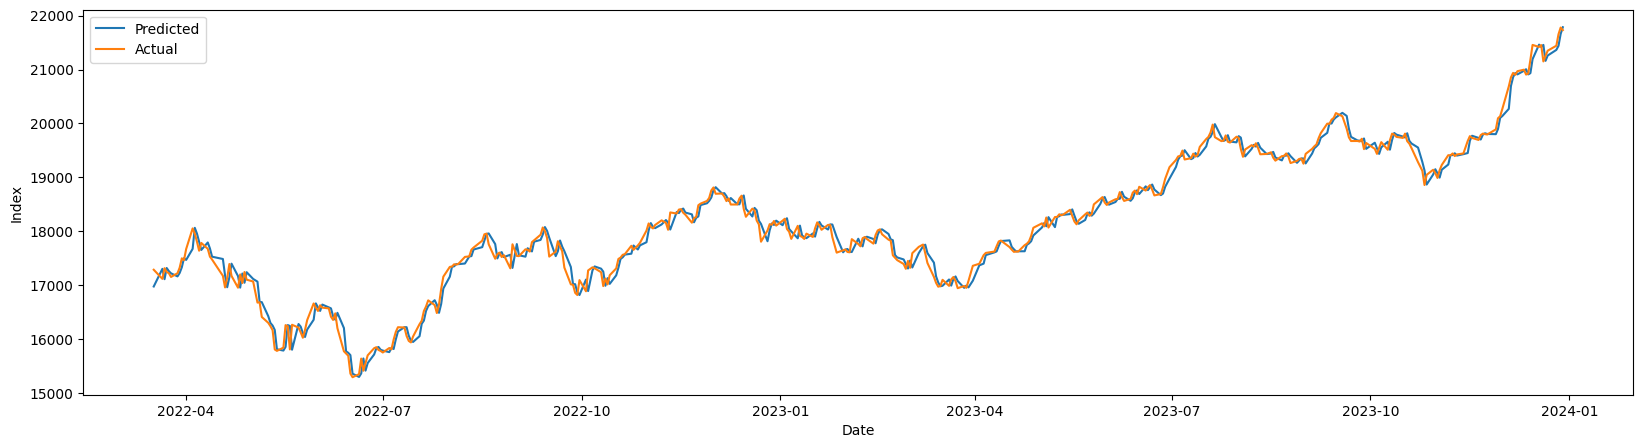

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(X_test.index,  (test_fcst))
plt.plot(X_test.index, (y_test))
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend(['Predicted', 'Actual'])
plt.show()

In [ ]:
evaluate_model_df = pd.DataFrame({
    "Model": ["Exponential Smoothing", "Moving Average", "ARIMA", "Linear Regression"],
    "MAE": [es_mae, ma_mae, arima_mae, lr_mae],
    "MSE": [es_mse, ma_mse, arima_mse, lr_mse],
    "RMSE": [es_rmse, ma_rmse, arima_rmse, lr_rmse],
    "MAPE": [es_mape, ma_mape, arima_mape, lr_mape],
    "R2": [es_r2, ma_r2, arima_r2, lr_r2]
})
evaluate_model_df

,Model,MAE,MSE,RMSE,MAPE,R2
0,Exponential Smoothing,2171.674000,6.474113e+06,2544.427741,11.003032,-4.532346
1,Moving Average,103.677709,1.651663e+04,128.517056,0.543866,0.984146
2,ARIMA,91.402974,1.318547e+04,114.827987,0.477385,0.988733
3,Linear Regression,109.160341,1.974110e+04,140.503023,0.610632,0.988458


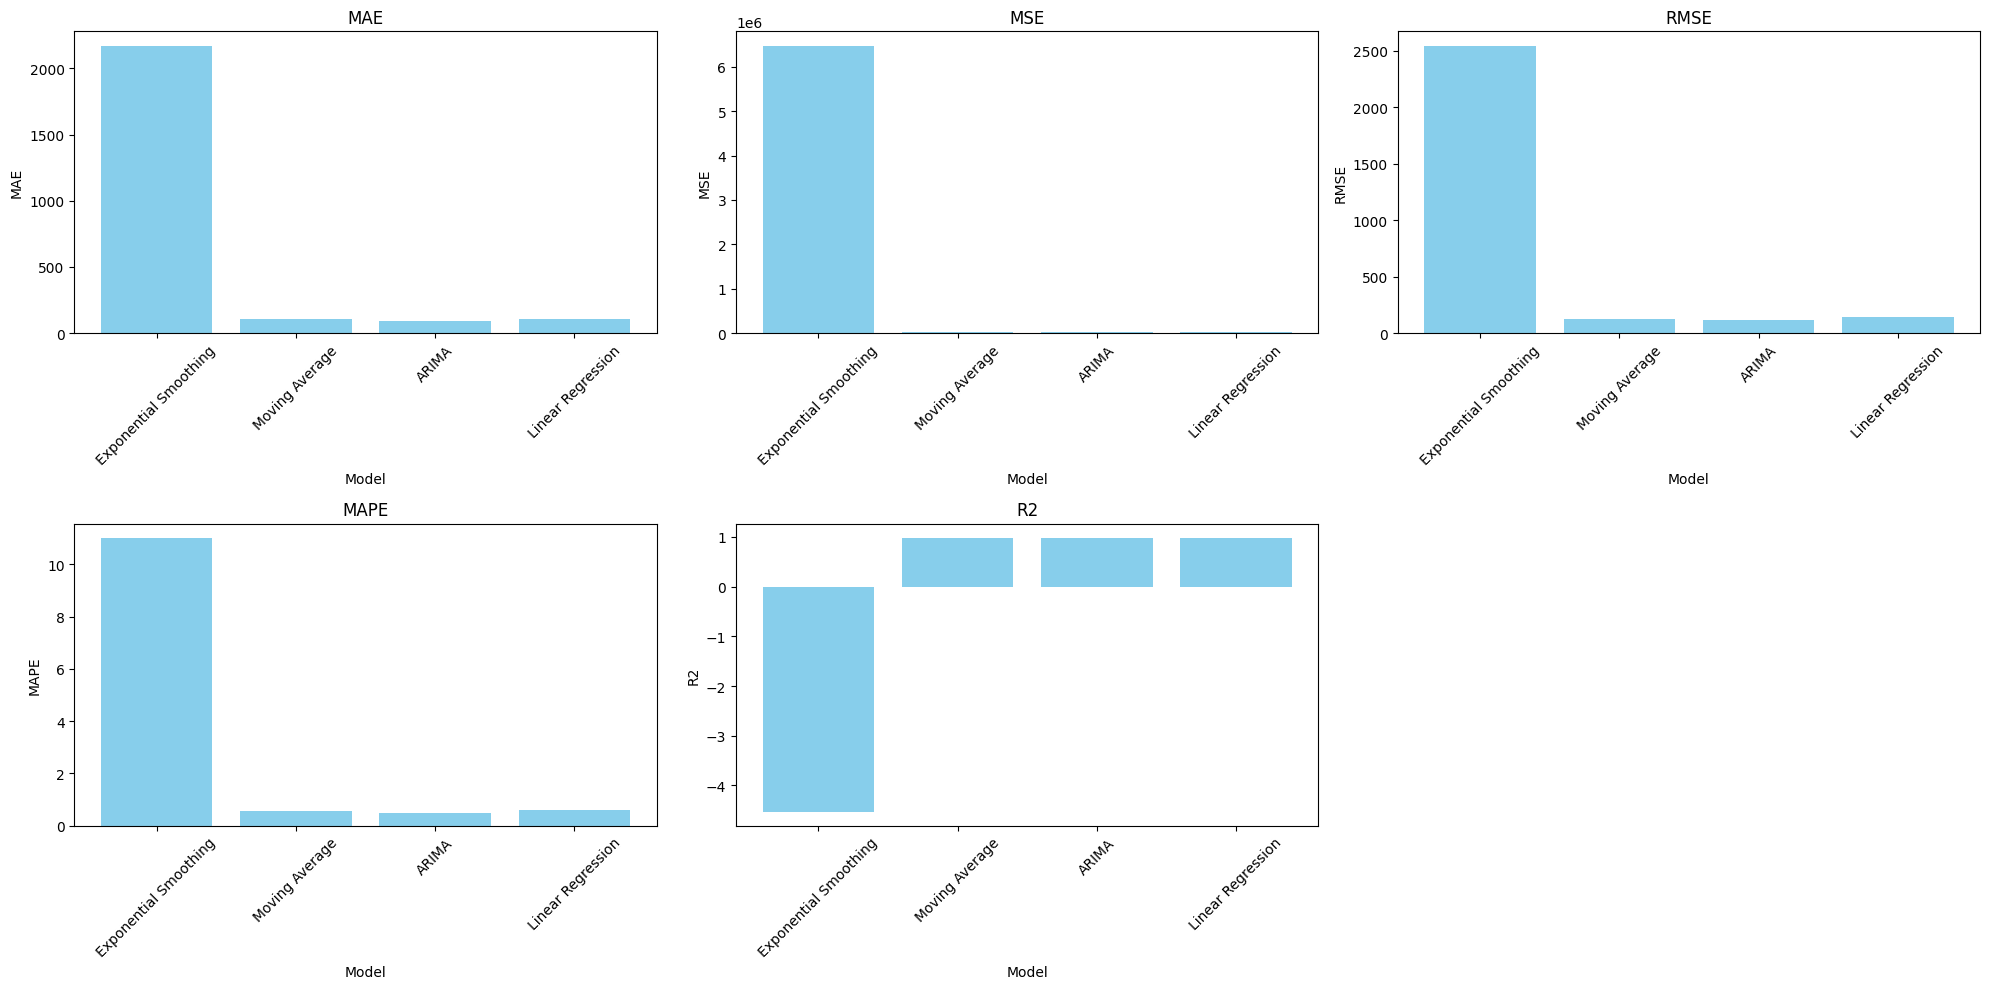

In [ ]:
metrics = ["MAE", "MSE", "RMSE", "MAPE", "R2"]

plt.figure(figsize=(20, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i + 1)
    plt.bar(evaluate_model_df["Model"], evaluate_model_df[metric], color='skyblue')
    plt.title(metric)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()